In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from load_data import *
from util import *
import copy
import gc
import time
import math
np.random.seed(43)

In [2]:
batch_size = 128
epochs = 70
acquired_points = 10
num_classes = 10
acquisition_times = 100
data_variances = [0.05, 0.02, 0.01, 0.1, 0.005]
device = torch.device("mps") if torch.mps.is_available() else "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else device
x_train_new, y_train_new, X_p, y_p, x_val, y_val, x_test, y_test = load_mnist()
x_train_new = x_train_new.to(dtype=torch.float32).to(device)
y_train_new = y_train_new.to(dtype=torch.float32).to(device)
X_p = X_p.to(dtype=torch.float32)
y_p = y_p.to(dtype=torch.float32)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_train shape: torch.Size([60000, 1, 28, 28])
60000 train samples, before reduction
10000 test samples


# VI utils

In [3]:
#This is actually treated as the std
weights_prior_std = 0.01
# This implies that the covariance matrix of each W_i is diag(weights_prior_var^2), ..., weights_prior_var^2)
sigma_1_inv = torch.diag(torch.ones(128) * (1.0 / (weights_prior_std ** 2)))

In [ ]:
class HierarchicalRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4), # -3 width/height
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4), # -3 width/height
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # /2 width/height,
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(32 * 11 * 11, 128),
            nn.ReLU()
        )

        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax()
        nn.init.normal_(self.fc2.weight, mean=0.0, std=weights_prior_std)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [5]:
def compute_pred_cov(sigma_2, model, x, blocks_of_cov_post):
    model.eval()
    y_ast = model(x)
    V_pred = torch.einsum('bd,kde,be->kb', y_ast, blocks_of_cov_post, y_ast).T
    idx = torch.arange(V_pred.shape[0] * sigma_2.shape[0], device=sigma_2.device) % sigma_2.shape[0]
    sigma_2_rep = sigma_2[idx]
    return V_pred + torch.reshape(sigma_2_rep, (V_pred.shape[0], -1))

In [6]:
def compute_pred_mean(model, x, posterior_mean):
    model.eval()
    y_ast = model(x)
    M_pred = y_ast @ posterior_mean.reshape((posterior_mean.shape[0], posterior_mean.shape[1])).T
    return M_pred

In [ ]:
class BayesianLastLayerModel(nn.Module):
    def __init__(self, compute_posterior_mean, compute_posterior_cov, feat_extractor, sigma2, feature_dim=128, **kwargs):
        super().__init__(**kwargs)

        self.feature_extractor = feat_extractor

        self.feature_dim = feature_dim
        self.output_dim = sigma2.shape[-1]

        self.M_ast = torch.zeros((self.output_dim, feature_dim), device=device)
        diag = torch.eye(feature_dim, device=device)
        idx = torch.arange(self.output_dim * diag.shape[0], device=diag.device) % diag.shape[0]
        
        self.V_ast = (weights_prior_std ** 2) * diag[idx].reshape(self.output_dim, feature_dim, feature_dim)
        self.compute_posterior_mean = compute_posterior_mean
        self.compute_posterior_cov = compute_posterior_cov
        self.sigma2 = sigma2.to(device=device)

    def fit_posterior(self, X, Y):
        self.M_ast = self.compute_posterior_mean(1, self.feature_extractor, X, Y, self.sigma2).reshape((self.output_dim, self.feature_dim)).detach()
        v_ast_blocks = self.compute_posterior_cov(1, self.feature_extractor, X, Y, self.sigma2).detach()
        if type(v_ast_blocks) == list:
          self.V_ast = torch.stack(v_ast_blocks)
        else: # is already stacked tensor
          self.V_ast = v_ast_blocks

    def sample_y_pred(self, x):
        """
        Draw y ~ N(M_pred, V_pred) V_pred is diagonal following the proof from the paper. This expects to have M_ast, V_ast already computed for the given X, Y.
        """
        M_hat = compute_pred_mean(self.feature_extractor, x, self.M_ast)
        V_hat = compute_pred_cov(self.sigma2, self.feature_extractor, x, self.V_ast)
        epsilon = torch.normal(torch.zeros((5, V_hat.shape[0], V_hat.shape[1])), torch.ones((5, V_hat.shape[0], V_hat.shape[1]))).to(device)
        V_hat = torch.unsqueeze(torch.sqrt(V_hat), 0)
        idx = torch.arange(5 * V_hat.shape[0], device=V_hat.device) % V_hat.shape[0]
        y_hat = M_hat + torch.sum(V_hat[idx] * epsilon, axis=0)
        return y_hat


    def forward(self, x):
        # sample = self.sample_y_pred(x)
        sample = compute_pred_mean(self.feature_extractor, x, self.M_ast)
        return sample

# Variational Inference Methods

In [8]:
def posterior_mean_mfvi_diag(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    p_t_p = y_pred.T @ y_pred
    p_t_y = y_pred.T @ Y
    m_ast = []

    for i in range(Y.shape[-1]):
        reg = (sigma_2[i] / (weights_prior_std ** 2)) * torch.eye(y_pred.shape[1], device=device)
        m_i_ast = torch.linalg.solve(reg + p_t_p, p_t_y[:,i:i+1])
        m_ast.append(m_i_ast)
    M_ast = torch.stack(m_ast)
    return M_ast

In [9]:
def posterior_mean_mfvi_full(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)

    n, K = y_pred.shape
    A = y_pred.T @ y_pred
    C = y_pred.T @ Y

    M_cols = []
    for i in range(Y.shape[1]):
        Ai = sigma_2[i] * A + (1 / (weights_prior_std ** 2)) * torch.eye(K, device=device)
        rhs_i = sigma_2[i] * C[:, i:i+1]
        sol_i = torch.linalg.solve(Ai, rhs_i)
        M_cols.append(sol_i)

    M_star = torch.concat(M_cols, axis=1)
    return M_star

In [10]:
def posterior_cov_mfvi_full(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)

    p_p_t = y_pred.T @ y_pred

    V_I_r = [] # only keep the block matrices on the diagonal. Rest is 0. Do not explicitly turn it into matrix
    for i in range(sigma_2.shape[0]):
        A_i = p_p_t * (1 / sigma_2[i]) + (1 / weights_prior_std ** 2) * torch.eye(p_p_t.shape[0], device=device)
        V_I_r.append(torch.linalg.inv(A_i))
    return torch.stack(V_I_r)

In [11]:
def posterior_cov_mfvi_diag(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    phi_r = torch.sum(y_pred ** 2, axis=0)

    denom = phi_r.unsqueeze(0) / (sigma_2 ** 2).unsqueeze(1) + 1.0 / (weights_prior_std ** 2)

    V_ast = 1.0 / denom
    V_ast = torch.diag_embed(V_ast)
    return V_ast

In [12]:
def posterior_cov_ai(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)

    sigmas_prime = []
    for i in range(num_classes):
        sigmas_prime_i = torch.linalg.inv((1 / (weights_prior_std ** 2)) * torch.eye(y_pred.shape[1], device=device) + (1 / sigma_2[i]) * (y_pred.T @ y_pred))
        sigmas_prime.append(sigmas_prime_i)
    return torch.stack(sigmas_prime, dim=0)

In [13]:
def posterior_mean_ai(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    sigmas_prime = posterior_cov_ai(T, model, X, Y, sigma_2)
    PhiY = y_pred.T @ Y
    scale = 1 / sigma_2
    phiY_scaled = PhiY * torch.unsqueeze(scale, dim=0)
    mu_prime = torch.einsum('mdk,km->md', sigmas_prime, phiY_scaled)

    return mu_prime

# Pipeline VI

In [14]:
vi_acq_functions = {"analytical_inference": (posterior_mean_ai, posterior_cov_ai), "mfvi_full": (posterior_mean_mfvi_full, posterior_cov_mfvi_full), "mfvi_diag": (posterior_mean_mfvi_diag, posterior_cov_mfvi_diag)}

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import gc

def find_best_decay_local_cnn(x_train, y_train, m_type=HierarchicalRegressor):
    weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
    best_score = 0
    best_model_state = None
    best_i = 0
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    for i, dec in enumerate(weight_decays):
        model = m_type().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=dec)
        total_loss = 0
        non_increasing = 0
        best_loss = None

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = rmse_loss(logits, yb.to(dtype=torch.float32))
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
            if best_loss is None or total_loss < best_loss:
                non_increasing = 0
                best_loss = total_loss
            else:
                if non_increasing == 4:
                    break
                non_increasing += 1
            total_loss = 0

        val_acc = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model)

        if val_acc > best_score or i == 0:
            best_score = val_acc
            best_i = i
            best_model_state = model.state_dict()

        del model # save space if running locally
        gc.collect()
        if device == "mps":
            torch.mps.empty_cache()
        elif device == "cuda":
            torch.cuda.empty_cache()

    best_model = m_type()
    best_model.load_state_dict(best_model_state)
    best_model = best_model.to(device=device)

    test_acc = evaluate(x_test.to(device=device), y_test.to(device=device), rmse_loss, best_model)
    return best_model, test_acc

In [16]:
def fit_pv(x_train_n, y_train_n, model: BayesianLastLayerModel):
    model.fit_posterior(x_train_n, y_train_n)
    return evaluate(x_test, y_test, rmse_loss, model)

In [17]:
def compute_var(T, model: BayesianLastLayerModel, x):
    V_ast = model.V_ast
    sigma2 = model.sigma2
    covs = compute_pred_cov(sigma2, model.feature_extractor, x, V_ast)
    return torch.sum(covs, dim=-1)

In [52]:
from itertools import product
def find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn):
    combinations = list(product(data_variances, repeat=y_train_cur.shape[-1]))
    best_model = None
    best_loss = None
    for sigmas in combinations:
        model_wrapper = BayesianLastLayerModel(post_mean_fn, post_cov_fn, cnn_layer, torch.Tensor(sigmas)).to(device=device)
        model_wrapper.fit_posterior(x_train_cur, y_train_cur)
        score = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model_wrapper)
        if best_loss is None or score < best_loss:
            best_model = model_wrapper
            best_loss = score
    test_score = evaluate(x_test, y_test, rmse_loss, best_model)
    return best_model, test_score

In [48]:

def find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn):
  best_model = None
  best_loss = None
  best_sigmas = None
  for sigma in data_variances:
    sigmas = [sigma for _ in range(y_train_cur.shape[-1])]
    model_wrapper = BayesianLastLayerModel(post_mean_fn, post_cov_fn, cnn_layer, torch.Tensor(sigmas)).to(device=device)
    model_wrapper.fit_posterior(x_train_cur, y_train_cur)
    score = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model_wrapper)
    if best_loss is None or score < best_loss:
      best_model = model_wrapper
      best_loss = score
      best_sigmas = sigmas
  print(best_sigmas)
  test_score = evaluate(x_test, y_test, rmse_loss, best_model)
  return best_model, test_score

In [20]:
def train_once_local_pred_var(x_train_cur, y_train_cur, Xs, cnn_layer, post_mean_fn, post_cov_fn, individual_variance=False, model_t=HierarchicalRegressor):
  cnn_mod, _ = find_best_decay_local_cnn(x_train_new, y_train_new, model_t)
  if individual_variance:
    model, test_score = find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
  else:
    model, test_score = find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
  acq_lambda = lambda x: compute_var(100, model, x)
  acq_scores = call_batchwise(acq_lambda, Xs, batch_size=64, device=device)
  x_new = acq_scores.topk(acquired_points).indices.cpu().numpy()
  return test_score, x_new

In [21]:
from tqdm import tqdm
def train_full_local_pv(acq_name, Xs, ys, x_init_train, y_init_train, cnn_layer, individual_variance=False, model_t=HierarchicalRegressor):
    post_mean_fn = vi_acq_functions[acq_name][0]
    post_cov_fn = vi_acq_functions[acq_name][1]
    scores = []
    x_train_cur = x_init_train.detach().clone()
    y_train_cur = y_init_train.detach().clone()
    for i in tqdm(range(acquisition_times)):
        score, x_new = train_once_local_pred_var(x_train_cur, y_train_cur, Xs, cnn_layer, post_mean_fn, post_cov_fn, individual_variance, model_t)
        x_new_t = torch.tensor(x_new, dtype=torch.long)
        x_train_cur = torch.cat([x_train_cur, Xs[x_new_t.cpu()].to(device)], dim=0)
        y_train_cur = torch.cat([y_train_cur, ys[x_new_t.cpu()].to(device)], dim=0)
        mask = torch.ones(Xs.shape[0], dtype=torch.bool)
        mask[x_new_t.cpu()] = False
        Xs = Xs[mask]
        ys = ys[mask]

        scores.append(score)

    cnn_mod, _ = find_best_decay_local_cnn(x_train_new, y_train_new, model_t)
    if individual_variance:
        model, final_score = find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
    else:
        model, final_score = find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
    scores.append(final_score)
    scores = torch.tensor(scores, dtype=torch.float32)

    return scores, model

In [22]:
import os
def train_acquisition_local_pv(acq_name, individual_variance=False, model_t=HierarchicalRegressor):
    os.makedirs("./vi_results", exist_ok=True)
    print("Start fitting model")
    if os.path.exists("./cnn_mod.keras"):
      cnn_mod = model_t()
      cnn_mod.load_state_dict(torch.load("./cnn_mod.pt", weights_only=True))
      cnn_mod = cnn_mod.to(device=device)
    else:
      cnn_mod, _ = find_best_decay_local_cnn(x_train_new, y_train_new)
      torch.save(cnn_mod.state_dict(), "./cnn_mod.pt")
    cnn_layer = cnn_mod.conv
    print("Model fitted")
    scores = []
    for i in range(3):
      if os.path.exists(f"./vi_results/{i}{str(acq_name)}.npy"):
        score = np.load(f"./vi_results/{i}{str(acq_name)}.npy")
        print(len(score))
        scores.append(score)
      else:
        score, model = train_full_local_pv(acq_name, X_p, y_p, x_train_new, y_train_new, cnn_layer, individual_variance, model_t)
        np.save(f"./vi_results/{i}{str(acq_name)}.npy", score.detach().cpu().numpy())
        print(score.detach())
        scores.append(score.detach().cpu().numpy())
    meaned_scores = torch.mean(torch.Tensor(np.stack(scores)), dim=0)

    return meaned_scores

In [23]:
results_local_vi = {}
for acq_fun in vi_acq_functions:
  res = train_acquisition_local_pv(acq_fun)
  print(res)
  np.save(f"./{str(acq_fun)}_local.npy", res.numpy())
  results_local_vi[acq_fun] = res

Start fitting model
Model fitted
101
101
101
tensor([0.3077, 0.3091, 0.3056, 0.3061, 0.3033, 0.3027, 0.3018, 0.2992, 0.2986,
        0.2964, 0.2958, 0.2948, 0.2943, 0.2924, 0.2910, 0.2913, 0.2923, 0.2898,
        0.2915, 0.2902, 0.2900, 0.2887, 0.2867, 0.2875, 0.2865, 0.2856, 0.2859,
        0.2853, 0.2852, 0.2861, 0.2868, 0.2882, 0.2851, 0.2842, 0.2849, 0.2850,
        0.2862, 0.2843, 0.2826, 0.2859, 0.2829, 0.2843, 0.2829, 0.2806, 0.2821,
        0.2809, 0.2811, 0.2802, 0.2826, 0.2782, 0.2808, 0.2826, 0.2822, 0.2803,
        0.2780, 0.2780, 0.2831, 0.2794, 0.2772, 0.2804, 0.2791, 0.2783, 0.2758,
        0.2786, 0.2796, 0.2786, 0.2797, 0.2806, 0.2774, 0.2777, 0.2794, 0.2781,
        0.2772, 0.2773, 0.2791, 0.2822, 0.2745, 0.2772, 0.2773, 0.2774, 0.2759,
        0.2762, 0.2768, 0.2771, 0.2790, 0.2777, 0.2755, 0.2755, 0.2765, 0.2757,
        0.2755, 0.2754, 0.2779, 0.2790, 0.2790, 0.2767, 0.2769, 0.2762, 0.2758,
        0.2785, 0.2770])
Start fitting model
Model fitted
101
101
101
tenso

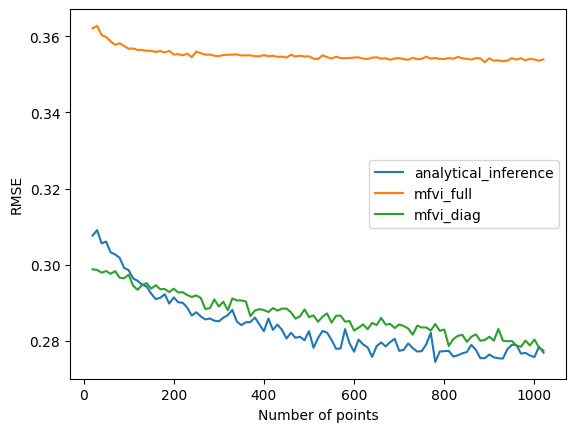

In [24]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
for key in results_local_vi:
  plt.plot(steps, results_local_vi[key], label=key)
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_acq_plot.svg")

# Neural Processes

In [25]:
# class NPModel(nn.Module):
#     def __init__(self, num_classes, moG=1):
#         super().__init__()
#         self.mog = moG

#         self.cnn = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(64, 64, kernel_size=1),
#             nn.ReLU()
#         )

#         self.attn = nn.MultiheadAttention(
#             embed_dim=64,
#             num_heads=1,
#             dropout=0.1,
#             batch_first=True
#         )

#         self.norm = nn.LayerNorm(64)

#         self.mean_head = nn.Sequential(
#             nn.Linear(7 * 7 * 64, num_classes * moG),
#         )

#         self.logvar_head = nn.Sequential(
#             nn.Linear(7 * 7 * 64, num_classes * moG),
#         )

#         self.num_classes = num_classes

#     def forward(self, x):
#         if x.dim() == 4 and x.shape[-1] == 1:
#             x = x.permute(0, 3, 1, 2)

#         x = self.cnn(x)
#         x = x.flatten(2).transpose(1, 2)

#         attn_out, _ = self.attn(x, x, x)
#         x = self.norm(x + attn_out)

#         mean = self.mean_head(x.flatten(1)).reshape((-1, self.num_classes, self.mog))
#         logvar = self.logvar_head(x.flatten(1)).reshape((-1, self.num_classes, self.mog))
#         res = torch.stack([mean, logvar], dim=-1)

#         return res

class NPModel(nn.Module):
    def __init__(self, in_channels=1, outputs=10, mog=1):
        super().__init__()
        self.outputs = outputs
        self.mog = mog

        # --- CNN backbone ---
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU()
        )

        self.out = nn.Linear(256, outputs * mog * 2)

    def forward(self, x):
        if x.dim() == 4 and x.shape[-1] == 1:
            x = x.permute(0, 3, 1, 2)
        batch_size = x.size(0)

        x = self.encoder(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)

        x = self.out(x)
        x = x.view(batch_size, self.outputs, self.mog, 2)

        return x

In [26]:
class NPInferenceModel(nn.Module):
  def __init__(self, np_model: NPModel):
    super().__init__()
    self.np_model = np_model

  def forward(self, z, **kwargs):
    mogs = self.np_model(z)
    eps = torch.normal(torch.zeros((z.shape[0], mogs.shape[1], mogs.shape[2])), torch.ones((z.shape[0], mogs.shape[1], mogs.shape[2]))).to(device=device)
    means = mogs[:, :, :, 0]
    log_vars = mogs[:, :, :, 1]
    return torch.sum(means + torch.sqrt(torch.exp(log_vars)) * eps, dim=-1)

In [27]:
def np_acquisition_fn(T, model, x):
  model.eval()
  mog = model(x.to(device=device))
  return torch.sum(torch.sum(torch.exp(mog[:, :, :, 1]), dim=-1), dim=-1).detach()

In [28]:
def call_batchwise_np_acq(model, x, batch_size=164):
  return torch.concat([np_acquisition_fn(1, model, x[i:i+batch_size]) for i in range(0, x.shape[0], batch_size)], dim=0)

In [29]:
def evaluate_np(model, x, y, batch_size=164):
  y_hat = torch.concat([model(x[i:i+batch_size]) for i in range(0, x.shape[0], batch_size)], dim=0)
  return rmse_loss(y, y_hat).detach()

In [30]:
def find_best_decay_np(x_train, y_train, x_val, y_val):
    weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
    best_score = 0
    best_model_state = None
    best_i = 0
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    for i, dec in enumerate(weight_decays):

        model = NPModel().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=dec)
        criterion = nll_logvar
        total_loss = 0
        non_increasing = 0
        best_loss = None

        for epoch in range(70):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(yb.to(dtype=logits.dtype), logits)
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
            if best_loss is None or total_loss < best_loss:
                non_increasing = 0
                best_loss = total_loss
            else:
                if non_increasing == 4:
                    break
                non_increasing += 1
            total_loss = 0

        inf_model = NPInferenceModel(model)
        val_acc = accuracy_classification(x_val, y_val, inf_model, device=device, batch_size=batch_size)
        val_acc = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, inf_model.to(device=device))
        

        if val_acc > best_score or i == 0:
            best_score = val_acc
            best_i = i
            best_model_state = model.state_dict()

        del model # save space if running locally
        gc.collect()
        if device == "mps":
            torch.mps.empty_cache()
        elif device == "cuda":
            torch.cuda.empty_cache()

    best_model = NPModel().to(device)
    best_model.load_state_dict(best_model_state)
    test_acc = evaluate(x_test.to(device=device), y_test.to(device=device), rmse_loss, NPInferenceModel(best_model).to(device=device))
    return best_model, test_acc

In [31]:
import os
def train_once_local_opt_np(x_train_cur, y_train_cur, Xs, i):
  if os.path.exists(f"./model_artifacts/np_model_new_{i}.pt"):
    model_curr = NPModel()
    model_curr.load_state_dict(torch.load(f"./model_artifacts/np_model_new_{i}.pt", weights_only=True))
    model_curr.to(device=device)
    test_score = evaluate_np(NPInferenceModel(model_curr).to(device=device), x_test.to(device), y_test.to(device))
  else:
    model_curr, test_score = find_best_decay_np(x_train_cur, y_train_cur, x_val, y_val)
    torch.save(model_curr.state_dict(), f"./model_artifacts/np_model_new_{i}.pt")
  acq_scores = call_batchwise_np_acq(model_curr, Xs, batch_size=512)
  x_new = acq_scores.topk(acquired_points).indices
  return test_score, x_new

In [37]:
from tqdm import tqdm
def train_full_local_np(Xs, ys, x_init_train, y_init_train):
  scores = []
  x_train_cur = x_init_train.detach().clone()
  y_train_cur = y_init_train.detach().clone()
  for i in tqdm(range(acquisition_times)):
    score, x_new = train_once_local_opt_np(x_train_cur, y_train_cur, Xs, i)
    x_new_t = torch.tensor(x_new, dtype=torch.long)
    x_train_cur = torch.cat([x_train_cur, Xs[x_new_t.cpu()].to(device)], dim=0)
    y_train_cur = torch.cat([y_train_cur, ys[x_new_t.cpu()].to(device)], dim=0)
    mask = torch.ones(Xs.shape[0], dtype=torch.bool)
    mask[x_new_t.cpu()] = False
    Xs = Xs[mask]
    ys = ys[mask]
    scores.append(score)

  model, score = find_best_decay_np(x_train_cur, y_train_cur, x_val, y_val)
  scores.append(score)
  return torch.Tensor(scores), model

In [38]:
def train_acquisition_np():
  os.makedirs("./model_artifacts", exist_ok=True)
  os.makedirs("./vi_results", exist_ok=True)
  scores = []
  for i in range(3):
    score, model = train_full_local_np(X_p, y_p, x_train_new, y_train_new)
    scores.append(score)
    print(score)
    np.save(f"./vi_results/{i}np_local.npy", score.detach().cpu().numpy())
  meaned_scores = torch.mean(torch.stack(scores), dim=0)

  return meaned_scores

In [39]:
res = train_acquisition_np()
print(res)
np.save(f"./vi_results/np_results.npy", res.numpy())

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/9_/b7fsj07x3p78x_60wdfj2z_h0000gn/T/ipykernel_52433/783859095.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new_t = torch.tensor(x_new, dtype=torch.long)
100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


tensor([0.4698, 0.4881, 0.4936, 0.4789, 0.4507, 0.4942, 0.4816, 0.4871, 0.5090,
        0.4886, 0.5024, 0.5419, 0.5596, 0.5395, 0.5394, 0.4512, 0.4276, 0.4598,
        0.4555, 0.4565, 0.4848, 0.4419, 0.4273, 0.5019, 0.5483, 0.4500, 0.4891,
        0.5589, 0.4429, 0.6127, 0.4192, 0.4731, 0.4893, 0.4639, 0.5033, 0.4421,
        0.5120, 0.4953, 0.4292, 0.5314, 0.5389, 0.5278, 0.6033, 0.4269, 0.5198,
        0.5502, 0.5295, 0.5291, 0.5222, 0.5294, 0.5313, 0.4612, 0.4670, 0.4680,
        0.4718, 0.5088, 0.5768, 0.4346, 0.4434, 0.5150, 0.5527, 0.4966, 0.4741,
        0.4499, 0.6006, 0.4088, 0.4561, 0.4214, 0.5069, 0.5240, 0.4557, 0.4407,
        0.4442, 0.4698, 0.5647, 0.5075, 0.3949, 0.4345, 0.4392, 0.5516, 0.4538,
        0.4807, 0.5035, 0.5860, 0.5239, 0.4094, 0.5481, 0.4339, 0.4745, 0.4745,
        0.4107, 0.4596, 0.4544, 0.5772, 0.4773, 0.5384, 0.4098, 0.4567, 0.3972,
        0.3974, 0.3929])


100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


tensor([0.4704, 0.4890, 0.4926, 0.4766, 0.4496, 0.4951, 0.4808, 0.4877, 0.5079,
        0.4883, 0.4992, 0.5441, 0.5611, 0.5381, 0.5409, 0.4525, 0.4288, 0.4590,
        0.4579, 0.4574, 0.4857, 0.4425, 0.4268, 0.5030, 0.5479, 0.4523, 0.4905,
        0.5575, 0.4446, 0.6141, 0.4198, 0.4712, 0.4893, 0.4670, 0.5033, 0.4417,
        0.5066, 0.4949, 0.4285, 0.5323, 0.5408, 0.5333, 0.6028, 0.4266, 0.5222,
        0.5544, 0.5308, 0.5302, 0.5203, 0.5329, 0.5344, 0.4633, 0.4658, 0.4666,
        0.4711, 0.5052, 0.5759, 0.4339, 0.4405, 0.5103, 0.5534, 0.4974, 0.4746,
        0.4513, 0.6055, 0.4101, 0.4578, 0.4229, 0.5101, 0.5258, 0.4554, 0.4414,
        0.4455, 0.4734, 0.5661, 0.5083, 0.3955, 0.4343, 0.4380, 0.5478, 0.4541,
        0.4801, 0.5043, 0.5862, 0.5258, 0.4082, 0.5487, 0.4330, 0.4711, 0.4707,
        0.4099, 0.4589, 0.4536, 0.5799, 0.4753, 0.5371, 0.4093, 0.4573, 0.3966,
        0.3968, 0.4198])


 10%|█         | 10/100 [00:15<02:23,  1.59s/it]


KeyboardInterrupt: 

In [ ]:
res = np.load('./vi_results/0np_local.npy')
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, res, label="Neural Process")
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_results/np_acq_plot.svg")

# Compare individual to constant variance

In [53]:
class HierarchicalRegressorEnergy(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=128, output_dim=3):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.last = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.conv(x)
        return self.last(x)

In [54]:
x_train_new, y_train_new, X_p, y_p, x_val, y_val, x_test, y_test = load_uci(val_size=1000)
device = torch.device("mps") if torch.mps.is_available() else "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else device
x_train_new = x_train_new.to(dtype=torch.float32).to(device)
y_train_new = y_train_new.to(dtype=torch.float32).to(device)
X_p = X_p.to(dtype=torch.float32)
y_p = y_p.to(dtype=torch.float32)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)
batch_size = 128
epochs = 70
acquired_points = 10
num_classes = 3
acquisition_times = 100
data_variances = [0.1, 0.25, 0.5, 1, 4, 8, 16]

In [55]:
def compute_individual():
  scores = []
  for i in range(1):
    score, model = train_full_local_pv("analytical_inference", X_p, y_p, x_train_new, y_train_new, None, True, HierarchicalRegressorEnergy)
    np.save(f"./vi_results/{i}ai_individual.npy", score.detach().cpu().numpy())
    print(score.detach())
    scores.append(score)
  meaned_scores = torch.mean(torch.stack(scores), dim=0)
  return meaned_scores

def compute_constant():
  scores = []
  for i in range(1):
    score, model = train_full_local_pv("analytical_inference", X_p, y_p, x_train_new, y_train_new, None, False, HierarchicalRegressorEnergy)
    np.save(f"./vi_results/{i}ai_constant.npy", score.detach().cpu().numpy())
    print(score.detach())
    scores.append(score)
  meaned_scores = torch.mean(torch.stack(scores), dim=0)
  return meaned_scores

In [ ]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, compute_individual(), label="Individual Variance")
plt.plot(steps, compute_constant(), label="Constant Variance")
plt.tight_layout()
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_individual_acq_plot.svg")

 16%|█▌        | 16/100 [03:39<18:22, 13.13s/it]